In [5]:
import numpy as np
import string 
import scipy.io
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
import itertools

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy

from sklearn.metrics import explained_variance_score

In [23]:
subject_id = 1

predicted = {}
target = {}
words = {}
label = "test"

predicted['glove_10'] = np.load("../log_root_cart_sub1/subject_1/word2brain/glove_linear/10/L2_DropIn8H5_wt/predicted_output_"+label+".npy")[0]
target['glove_10'] = np.load("../log_root_cart_sub1/subject_1/word2brain/glove_linear/10/L2_DropIn8H5_wt/target_output_"+label+".npy")

model = 'glove_10'
cosine_dists = distance.cdist(predicted[model],target[model],'cosine')
euc_dists =  distance.cdist(predicted[model],target[model],'euclidean')

predicted['contextual_01'] = np.load("../log_root_cart_sub1/word2brain/contextual_01_avg/intended/L2_DropIn8H5/predicted_output_"+label+".npy")
target['contextual_01'] = np.load("../log_root_cart_sub1/word2brain/contextual_01_avg/intended/L2_DropIn8H5/target_output_"+label+".npy")
words['contextual_01'] = np.load("../log_root_cart_sub1/word2brain/contextual_01_avg/intended/L2_DropIn8H5/words_"+label+".npy")

model = 'contextual_01'
cosine_dists = distance.cdist(predicted[model],target[model],'cosine')
euc_dists =  distance.cdist(predicted[model],target[model],'euclidean')

In [24]:
print(predicted['glove_10'].shape)
print(target['glove_10'].shape)

print("explained variance for glove:",explained_variance_score(target['glove_10'], predicted['glove_10'],multioutput='uniform_average'))
print("explained variance for contextual_01:",explained_variance_score(target['contextual_01'], predicted['contextual_01'],multioutput='uniform_average'))

explained_variances = {}
explained_variances['glove_10'] = explained_variance_score(target['glove_10'], predicted['glove_10'],multioutput='raw_values')
explained_variances['contextual_01'] = explained_variance_score(target['contextual_01'], predicted['contextual_01'],multioutput='raw_values')

best_indexes={}
best_indexes['glove_10'] = np.argsort(explained_variances['glove_10'])
best_indexes['contextual_01'] = np.argsort(explained_variances['contextual_01'])

print(explained_variances['glove_10'][best_indexes['glove_10']])


(361, 37913)
(361, 37913)
explained variance for glove: -0.023592206012628666
explained variance for contextual_01: -0.009012451649176356
[-0.84475558 -0.35724334 -0.33790614 ...  0.10665233  0.11173675
  0.15551066]


In [25]:
print("max explained variance for contextual_01:",
      np.max(explained_variance_score(target['contextual_01'], predicted['contextual_01'],multioutput='raw_values')))

print("max explained variance for glove_10:",
      np.max(explained_variance_score(target['glove_10'], predicted['glove_10'],multioutput='raw_values')))

print("min explained variance for contextual_01:",
      np.min(explained_variance_score(target['contextual_01'], predicted['contextual_01'],multioutput='raw_values')))

print("min explained variance for glove_10:",
      np.min(explained_variance_score(target['glove_10'], predicted['glove_10'],multioutput='raw_values')))


max explained variance for contextual_01: 0.4131956343778881
max explained variance for glove_10: 0.15551065980349554
min explained variance for contextual_01: -3.629754379279852
min explained variance for glove_10: -0.8447555810541363


In [ ]:
sorted_indexes = np.argsort(euc_dists,axis=1)

In [ ]:
prec_at_corrects = []
ranks = []

for i in np.arange(len(predicted['glove_10'])):
    print(i)
    correct_at = np.where(sorted_indexes[i] == i)[0] + 1
    print("Reciprocal Rank",correct_at)
    prec_at_correct = 1.0/correct_at
    print("precision at ",correct_at,": ",prec_at_correct)
    prec_at_corrects.append(prec_at_correct)
    ranks.append(correct_at)
    
print("MRR: ",np.mean(prec_at_corrects)," ",np.mean(ranks))

In [ ]:
true_mu = 361 / 2.0

onesample_results = scipy.stats.ttest_1samp(ranks, true_mu)
print("ranks: ", onesample_results)

In [ ]:
def eval(dists,e_dists,model):
    nn_index = np.argmin(dists,axis=1)
    accuracy_on_test = np.mean(nn_index == np.argmax(np.eye(len(target[model])),axis=1))


    b_acc = []
    e_b_acc = []
    dic = {}
    for i,j in itertools.combinations(np.arange(len(target[model])), 2):
            dic[i] = []
            dic[j] = []

        
    for i,j in itertools.combinations(np.arange(len(target[model])), 2):
        right_match = dists[i,i] + dists[j,j]
        wrong_match = dists[i,j] + dists[j,i]
        b_acc.append(right_match < wrong_match)

        e_right_match = e_dists[i,i] + e_dists[j,j]
        e_wrong_match = e_dists[i,j] + e_dists[j,i]
        e_b_acc.append(e_right_match < e_wrong_match)
        
        #print(i,j,b_acc)
        dic[i].append(right_match < wrong_match)
        dic[j].append(right_match < wrong_match)
        

    #print("binary accuracy: ", np.mean(b_acc)," ", np.mean(e_b_acc))
    return np.mean(b_acc),np.mean(e_b_acc),b_acc,e_b_acc,dic

In [ ]:
mean_b_acc, mean_e_b_acc,b_acc, e_b_acc = eval(cosine_dists,euc_dists,model)
number_of_trues = len(np.where(np.asarray(b_acc) == True)[0]) / len(b_acc)
number_of_falses = len(np.where(np.asarray(b_acc) == False)[0])/ len(b_acc)

In [ ]:
print(scipy.stats.chisquare([number_of_trues,number_of_falses],[0.5,0.5]))

In [ ]:
true_mu = .50
print(np.mean(b_acc))
onesample_results = scipy.stats.ttest_1samp([np.mean(b_acc),np.mean(e_b_acc)], true_mu)
print("binary accuracy: ", onesample_results)

In [ ]:
number_of_falses

In [ ]:
dists = cosine_dists

nn_index = np.argmin(dists,axis=1)
accuracy_on_test = np.mean(nn_index == np.argmax(np.eye(len(target[model])),axis=1))

In [ ]:
dists

In [ ]:
predicted['glove_10'] = np.load("../log_root_cart_sub1/subject_1/word2brain/glove_linear/10/L2_DropIn8H5_wt/predicted_output_"+label+".npy")[0]
target['glove_10'] = np.load("../log_root_cart_sub1/subject_1/word2brain/glove_linear/10/L2_DropIn8H5_wt/target_output_"+label+".npy")
words['glove_10'] = np.load("../log_root_cart_sub1/subject_1/word2brain/glove_linear/10/L2_DropIn8H5_wt/words_"+label+".npy")

print(len(target['glove_10']))
model = 'glove_10'
cosine_dists = distance.cdist(predicted[model],target[model],'cosine')
euc_dists =  distance.cdist(predicted[model],target[model],'euclidean')

In [ ]:
len(words['glove_10'])

In [ ]:
_,_,b_acc,e_b_acc, dic = eval(cosine_dists,euc_dists,model)

In [ ]:
for i in np.arange(len(words[model])):
    print(words[model][i],np.mean(dic[i]))

In [31]:
print('subject_'+str(subject_id)+'.mat')

subject_file = scipy.io.loadmat('subject_'+str(subject_id)+'.mat') 
sub_id_index = 0
#nTRs
number_of_scans_index = 1
#nvoxels
number_of_voxels = 2
x_dim_index = 3
y_dim_index = 4
z_dim_index = 5
#colToCoord
colToCoord_index = 6
#coordToCol
coordToCol_index = 7
ROInumToName_index = 8
ROInumsToName_3d_index = 9
ROINames_index = 10
voxel_size_index = 11
#the map to the MNI space
matrix_index = 12
number_of_voxels = len(subject_file['meta'][0][0][ROInumToName_index][0])
area_names_list = np.asarray(subject_file['meta'][0][0][ROINames_index][0])

voxel_area_dic = {}
for i in np.arange(number_of_voxels):
    if subject_file['meta'][0][0][ROInumToName_index][0][i] not in voxel_area_dic.keys():
        voxel_area_dic[subject_file['meta'][0][0][ROInumToName_index][0][i]]=[]
        
    voxel_area_dic[subject_file['meta'][0][0][ROInumToName_index][0][i]].append(i)

subject_1.mat


In [32]:


area_wise_mse = {}
whole_accuracy = {}
for model in predicted.keys():
    print(model)
    area_wise_mse[model] = {}
    dist_sum = 0
    
    whole_accuracy[model] = np.mean(explained_variances[model])
    for key in voxel_area_dic.keys():
        #print("area name:", subject_file['meta'][0][0][ROINames_index][0][key][0])
        #print("number of voxels:",len(voxel_area_dic[key]))
        #mse_vector = np.sum(((predicted[model][:,voxel_area_dic[key]] - target[model][:,voxel_area_dic[key]] ) ** 2),axis=1)
        #mse_vector = cosine_dists.diagonal()
        #dist_sum += np.sum(mse_vector) 
        area_wise_mse[model][subject_file['meta'][0][0][ROINames_index][0][key][0]] = \
                                                np.mean(explained_variances[model][voxel_area_dic[key]])
        
        
        

glove_10
contextual_01


In [33]:
for model in area_wise_mse.keys():
    print(model)
    values = []
    areas = []
    for area in area_wise_mse[model].keys():
        #print("%s,%f" %(area,area_wise_mse[model][area]))
        values.append(area_wise_mse[model][area])
        areas.append(area)
    ind = np.argsort(values)
    print(areas[ind[-1]],values[ind[-1]], areas[ind[-2]],values[ind[-2]],areas[ind[-3]],values[ind[-3]])
    print(areas[ind[-4]],values[ind[-4]], areas[ind[-5]],values[ind[-5]],areas[ind[-6]],values[ind[-6]])
    print(np.mean(values))
    print(whole_accuracy[model])

glove_10
Pallidum_R -0.005854014475269066 Thalamus_L -0.0071022589244956425 Putamen_R -0.009325117990748706
Caudate_R -0.00950910602329092 Pallidum_L -0.01132803951175081 Thalamus_R -0.011340253785132915
-0.022335840375149903
-0.023592206012628666
contextual_01
Frontal_Inf_Oper_L 0.08541907231604487 Rectus_L 0.07795482941133033 Frontal_Mid_L 0.06411180195708045
Frontal_Med_Orb_L 0.06331493840271567 Rolandic_Oper_L 0.0629579374205156 Temporal_Mid_L 0.057507376213153535
-0.0034187536405778404
-0.009012451649176356


[47 63 70 61 34 81 72 45 24 60 35 79 87 13 46 48 20 22 52 49 44 82 29 64
 32 88 16 84 68 66 71 51 17 50 67 23 85 77 59 80 89 26 65 38 11 25 42 73
 30  8 86 74 53 83  7 36  4  0 76 78  3  1 39  2 19 69 12 54 55  5 28 40
 56  9 10 37 75 27 33 57 58 14 18 62  6 15 41 31 43 21]


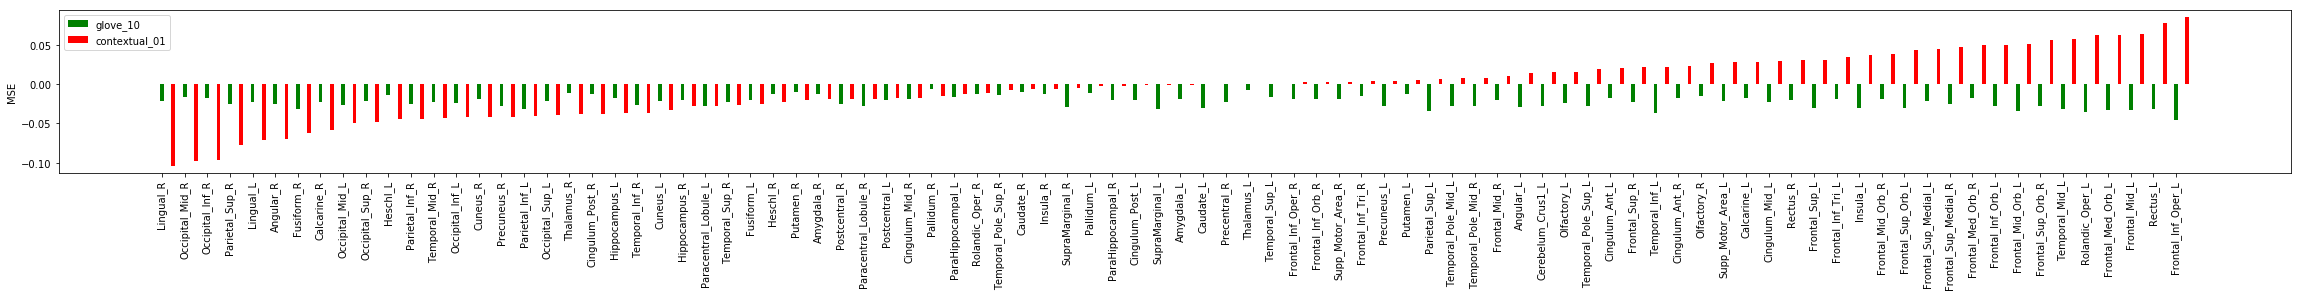

In [38]:
import numpy as np
import matplotlib.pyplot as plt

values = list(area_wise_mse['contextual_01'].values())

sorted_ind = np.argsort(values)
print(sorted_ind)
N = len(area_wise_mse['contextual_01'].keys())

ind = np.arange(0,N*3,3)  # the x locations for the groups
width = 0.5       # the width of the bars

fig, ax = plt.subplots(figsize=(40,3))
rects1 = ax.bar(ind,np.asarray(list(area_wise_mse['glove_10'].values()))[sorted_ind], width, color='green',align='center')
rects4 = ax.bar(ind+0.5*3,np.asarray(list(area_wise_mse['contextual_01'].values()))[sorted_ind], width, color='red',align='center')

                    
# add some text for labels, title and axes ticks
ax.set_ylabel('MSE')
ax.set_xticks(ind)
ax.set_xticklabels(np.asarray(list(area_wise_mse['glove_10'].keys()))[sorted_ind],rotation='vertical')

ax.legend((rects1,rects4),(["glove_10","contextual_01"]))
plt.show()